In [7]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install pytorch-lightning
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 700 kB 14.1 MB/s 
     |████████████████████████████████| 5.8 MB 73.3 MB/s 
     |████████████████████████████████| 596 kB 76.7 MB/s 
     |████████████████████████████████| 141 kB 73.5 MB/s 
     |████████████████████████████████| 419 kB 59.9 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followin

In [8]:
# Get Datset
# https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('*==========Train Set==========*')
print(train_set)
print('*========== Test Set ==========*')
print(test_set)

Files already downloaded and verified
Files already downloaded and verified
*==========Train Set==========*
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
*========== Test Set ==========*
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


(3, 32, 32)
truck-9


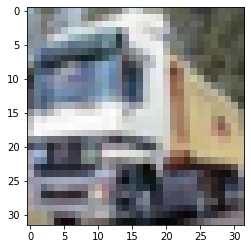

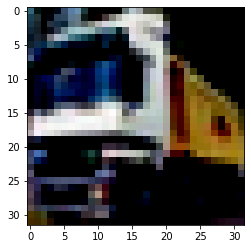

In [9]:
import matplotlib.pyplot as plt
import numpy as np

img = train_set[1][0]
label = train_set[1][1]
img = img.numpy()

print(img.shape)
print(f'{classes[label]}-{label}')

origin_img = img / 2 + 0.5 # unnormalized
plt.imshow(np.transpose(origin_img, (1, 2, 0)))
plt.show()


plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [10]:
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule

class CustomDataModule(LightningDataModule):
  def __init__(self, training_set, test_set, batch_size=128, num_workers=2):
    super().__init__()
    self.training_set = training_set
    self.test_set = test_set

    # set parameters
    self.batch_size = batch_size
    self.num_workers = num_workers

  #how to make a batch
  def collate_function(self, batch):    
    new_x = [x.flatten() for x, _ in batch]
    new_y = [torch.tensor(y, dtype=torch.long) for _, y in batch]
    return [torch.stack(new_x), torch.stack(new_y)]

  def train_dataloader(self):
    return DataLoader(self.training_set, batch_size=self.batch_size, 
                      num_workers=self.num_workers, shuffle=True, 
                      collate_fn=self.collate_function)
    
  def test_dataloader(self):
    return DataLoader(self.test_set, batch_size=self.batch_size, 
                      num_workers=self.num_workers, 
                      collate_fn=self.collate_function)
    
# data_module = CustomDataModule(train_set, test_set)
# trainer.fit(model, datamodule = data_module)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class DeepNeuralNet(nn.Module):
  def __init__(self, input_size, label_size, layer_size=64):
    super().__init__()
    self.input_size = input_size
    self.layer_size = layer_size
    self.label_size = label_size
    self.set_layer()
  
  def set_layer(self):
    # Build layer
    self.first_layer = nn.Linear(self.input_size, self.layer_size)
    self.second_layer = nn.Linear(self.layer_size, self.layer_size)
    self.last_layer = nn.Linear(self.layer_size, self.label_size)

  def forward(self, x):
    # Define operation
    x = self.first_layer(x)
    x = F.relu(x)
    x = self.second_layer(x)
    x = F.relu(x)
    x = self.last_layer(x)
    
    return x

In [12]:
from pytorch_lightning import LightningModule

from torch.nn import CrossEntropyLoss, Softmax
from torch.optim import Adam

class LitCIFAR10Model(LightningModule):
  def __init__(self, model, learning_rate=1e-3):
    super().__init__()
    self.model =  model
    self.lr = learning_rate

  def forward(self, x):
    out = self.model(x)
    return Softmax(dim=1)(out)

  def configure_optimizers(self):
    optimizer=Adam(self.parameters(), lr=self.lr)
    return optimizer
 
  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = self.loss_function(logits, y)
    predict = torch.argmax(logits, dim=1)    
    return {'loss': loss, 'predict': predict, 'answer': y}

  def training_epoch_end(self, outputs):
    loss = [output['loss'] for output in outputs]
    avg_loss = sum(loss) / len(outputs)
    self.logger.experiment.add_scalar("Loss/Epoch",
                                      avg_loss,
                                      self.current_epoch)

  def predict_step(self, batch, batch_idx):
    x, y = batch
    logits = self.model(x)
    predict = torch.argmax(logits, dim=1)
    return predict
  
  def loss_function(self, output, target):
    return CrossEntropyLoss()(output, target)

In [13]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger('./log_DeepNN', name="LitCIFAR10-DeepNN-Adam-128,1e-3")
data_module = CustomDataModule(train_set, test_set)

architecture = DeepNeuralNet(32*32*3, 10) #32*32(pixels)*3 channels, labels
model = LitCIFAR10Model(architecture)

trainer = Trainer(max_epochs=10, accelerator='gpu', devices=[0], logger=logger)
#trainer = Trainer(max_epochs=10, accelerator='cpu', logger=logger)

trainer.fit(model, datamodule=data_module)

MisconfigurationException: ignored

# 새 섹션

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "./log_DeepNN"

In [ ]:
predict = trainer.predict(model, dataloaders=data_module.test_dataloader())
predict = torch.cat(predict)

answer = [batch[1] for batch in data_module.test_dataloader()]
answer = torch.cat(answer)

correct = (predict == answer).sum()
total = answer.shape[0]
accuracy = correct / total

print(f'correct: {correct}, total: {total}, accuracy: {accuracy}')


# You can use torchmetrics
import torchmetrics

acc = torchmetrics.functional.accuracy(predict, answer)
print(f"accuracy-torchmetrics: {acc}")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Conv2D(nn.Module):
  def __init__(self, label_size):
    super().__init__()
    self.label_size = label_size
    self.set_layer()
  
  def set_layer(self):
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x   


In [ ]:
class Custom2DDataModule(LightningDataModule):
  def __init__(self, training_set, test_set, batch_size=128, num_workers=2):
    super().__init__()
    self.training_set = training_set
    self.test_set = test_set

    # set parameters
    self.batch_size = batch_size
    self.num_workers = num_workers

  def train_dataloader(self):
    return DataLoader(self.training_set, batch_size=self.batch_size, 
                      num_workers=self.num_workers, shuffle=True,)
    
  def test_dataloader(self):
    return DataLoader(self.test_set, batch_size=self.batch_size, 
                      num_workers=self.num_workers,)

In [ ]:
data_module = Custom2DDataModule(train_set, test_set)

logger = TensorBoardLogger('./log_Conv2D', name="LitCIFAR10-Conv2D-Adam-128,1e-3", log_graph=True,)

architecture = Conv2D(10)
model = LitCIFAR10Model(architecture)
trainer = Trainer(max_epochs=10, accelerator='gpu', devices=[0], logger=logger)
#trainer = Trainer(max_epochs=10, accelerator='cpu', logger=logger)

trainer.fit(model, datamodule=data_module)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "./log_Conv2D"

In [ ]:
import torchmetrics

predict = trainer.predict(model, dataloaders=data_module.test_dataloader())
predict = torch.cat(predict)

answer = [batch[1] for batch in data_module.test_dataloader()]
answer = torch.cat(answer)

acc = torchmetrics.functional.accuracy(predict, answer)
print(f"accuracy-torchmetrics: {acc}")